In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Read In Data

In [2]:
df = pd.read_csv("assignment7s_dataset.csv")

In [3]:
# get info

print(f'shape: {df.shape}')
print(f'columns: {df.columns}')
print(f'\ndata types:\n{df.dtypes}')

shape: (750, 2)
columns: Index(['f1', 'f2'], dtype='object')

data types:
f1    float64
f2    float64
dtype: object


In [4]:
# oberve
df.head()

,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937


In [5]:
# check for NaN entries
df.isnull().any()

f1    False
f2    False
dtype: bool

# Problem #1

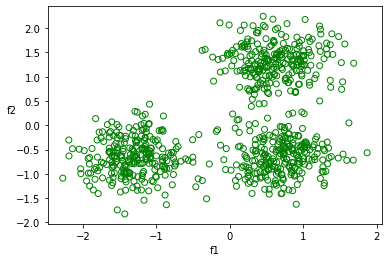

In [6]:
# plot points to observe clusters
plt.scatter(df.f1, df.f2, color='g', facecolors='none')
plt.xlabel('f1')
plt.ylabel('f2', rotation='horizontal')
plt.show()

From the plot above, we expect there to be 3 distinct clusters, and thus 3 species

# Problem #2

Starting witht he lower left cluster as cluster 1 and going clockwise, by oberving the points in the plot we can infer the feature ranges.

| Cluster | f1 range | f2 range |
| --- | --- | --- |
| 1 | [-2, -1] | [-1.5, 0] |
| 2 | [0, 1.5] | [0.5, 2] |
| 3 | [0, 1.5] | [-1.5, 0] |

# Problem #3

In [7]:
class KMeans:
    
    def __init__(self, k=3, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    
    def fit(self, data):
        # initialize centroid list
        self.centroids = {}
        
        # initialize k centroids
        for i in range(self.k):
            rand_index = np.random.randint(0, data.shape[1]+1)
            self.centroids[i] = data[rand_index]

        # run k-means
        for i in range(self.max_iter):
            # dictionary that separates samples based on their associated cluster
            self.classifications = {}
            
            # create dictionary for k classes
            for j in range(self.k):
                self.classifications[j] = []
            
            # determine centroid class for each sample in data
            for sample in data:
                # calculate distance between all centroids and current sample
                distances = [np.linalg.norm(sample - self.centroids[centroid]) for centroid in self.centroids]
                
                # find closest centroid and label sample
                classification = distances.index(min(distances))
                self.classifications[classification].append(sample)
            
            prev_centroids = dict(self.centroids)
            
            # update centroids
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
                
            # check if k-means requires further iteration
            optimized = True
            
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid - original_centroid) / original_centroid * 100) > self.tol:
                    optimized = False
            
            if optimized:
                print(f'K-means optimized after {i} iterations')
                break

In [8]:
# run k-means on dataset
model = KMeans()
model.fit(df.values)

K-means optimized after 4 iterations


In [9]:
# get centroids
centroids = model.centroids
pprint(centroids)

{0: array([-1.30266211, -0.65704205]),
 1: array([ 0.6954587 , -0.64442334]),
 2: array([0.62260555, 1.3172598 ])}


In [10]:
# get points for each cluster
cluster0 = model.classifications[0]
cluster1 = model.classifications[1]
cluster2 = model.classifications[2]

print(f'cluster0: {len(cluster0)} points\ncluster1: {len(cluster1)} points\ncluster2: {len(cluster2)} points')

cluster0: 252 points
cluster1: 250 points
cluster2: 248 points


In [11]:
# observe sample points in cluster
pprint(cluster0[:3])

[array([-1.42808099, -0.83706377]),
 array([-1.2615699 ,  0.27188135]),
 array([-1.30154775, -0.76206203])]


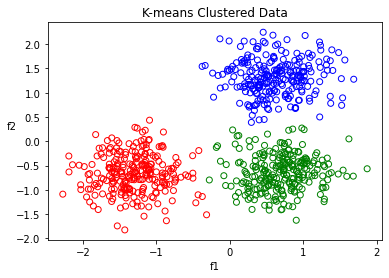

In [12]:
# plot points grouped with their cluster
plt.scatter([x[0] for x in cluster0], [y[1] for y in cluster0], color='r', facecolors='none')
plt.scatter([x[0] for x in cluster1], [y[1] for y in cluster1], color='g', facecolors='none')
plt.scatter([x[0] for x in cluster2], [y[1] for y in cluster2], color='b', facecolors='none')

plt.xlabel('f1')
plt.ylabel('f2', rotation='horizontal')
plt.title('K-means Clustered Data')

plt.show()

In [13]:
# round values to 5 decimals
def round5(x):
    return round(x, 5)

In [14]:
# calculate distances from points to their respective centroid
def dist(data, centroid):
    distances = [np.linalg.norm(i - centroid) for i in data]
    
    # convert to numpy array with correct shape
    distances = np.array(distances).reshape(len(distances), 1)
    
    new_data = np.append(data, distances, axis=1)
    
    df = pd.DataFrame(new_data, columns=['f1', 'f2', 'dist_to_centroid'])
    
    df['dist_to_centroid'].apply(round5)
    
    return df

In [15]:
dist0 = dist(cluster0, centroids[0])
dist1 = dist(cluster1, centroids[1])
dist2 = dist(cluster2, centroids[2])

In [16]:
# obesrve
dist0.head()

,f1,f2,dist_to_centroid
0,-1.428081,-0.837064,0.219403
1,-1.261570,0.271881,0.929832
2,-1.301548,-0.762062,0.105026
3,-1.215782,-0.601021,0.103375
4,-1.250218,-1.057617,0.403993


We will classify an outlier as being greater than 2 standard deviations away from the average distance from a point to its respective centroid.

In [17]:
def get_outliers(df):
    _df = df.copy(deep=True)
    
    avg_dist = round5(_df['dist_to_centroid'].mean())
    std = round5(_df['dist_to_centroid'].std())
    
    # classify outliers as points > 2std from mean centroid distance
    threshold = avg_dist + (2*std)
    
    _df = _df[(_df['dist_to_centroid'] > threshold)]
    _df_data = _df.iloc[:,0:2].values
    
    print(f'avg distance to centroid: {avg_dist} {chr(177)} {std}')
    
    return _df, _df_data

In [18]:
# identify outliers

# cluster 0
outdf0, outData0 = get_outliers(dist0)

avg distance to centroid: 0.47635 ± 0.25144


In [19]:
# cluster 1
outdf1, outData1 = get_outliers(dist1)

avg distance to centroid: 0.46265 ± 0.23664


In [20]:
# cluster 2
outdf2, outData2 = get_outliers(dist2)

avg distance to centroid: 0.4783 ± 0.24766


In [21]:
outData2

array([[-0.13447918,  2.11039748],
       [ 1.48201718,  1.82713556],
       [ 1.22425496,  0.50161091],
       [ 1.53624088,  0.89460489],
       [ 1.68745105,  1.27830756],
       [ 1.52307352,  0.74115752],
       [-0.00943759,  2.06614833],
       [-0.33579552,  1.56140541],
       [-0.37672226,  1.54300065],
       [ 0.29375547,  0.38990412],
       [ 1.5667784 ,  1.67458369]])

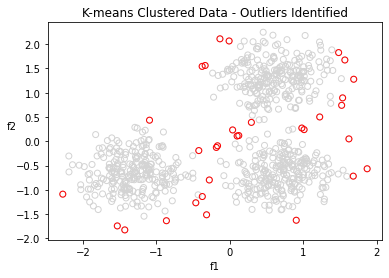

In [22]:
# observe outliers
plt.scatter([x[0] for x in cluster0], [y[1] for y in cluster0], color='lightgray', facecolors='none')
plt.scatter([x[0] for x in cluster1], [y[1] for y in cluster1], color='lightgray', facecolors='none')
plt.scatter([x[0] for x in cluster2], [y[1] for y in cluster2], color='lightgray', facecolors='none')

plt.scatter([x[0] for x in outData0], [y[1] for y in outData0], color='r', facecolors='none')
plt.scatter([x[0] for x in outData1], [y[1] for y in outData1], color='r', facecolors='none')
plt.scatter([x[0] for x in outData2], [y[1] for y in outData2], color='r', facecolors='none')

plt.xlabel('f1')
plt.ylabel('f2', rotation='horizontal')
plt.title('K-means Clustered Data - Outliers Identified')

plt.show()

# Problem #4

In [23]:
class DBSCAN():
    def __init__(self, eps=0.5, MinPnts=7):
        self.eps = eps
        self.MinPnts = MinPnts
    
    def fit(self, data):
        self.labels = [0] * len(data)
        
        # initialize id for each cluster group
        cluster_id = 0
        
        for point in range(len(data)):
            
            if not (self.labels[point] == 0):
                continue
            
            # get indices of neighboring points
            neighbor_points = self.check_neighbors(data, point)
            
            # check if number of neighboring points < MinPnts
            if len(neighbor_points) < self.MinPnts:
                self.labels[point] = -1
            else:
                cluster_id += 1
                self.grow_cluster(data, point, neighbor_points, cluster_id)
        
    
    def check_neighbors(self, data, point):
        neighbors = []
        
        for other_points in range(len(data)):
            if np.linalg.norm(data[other_points] - data[point]) < self.eps:
                
                # save indices of neighboring points
                neighbors.append(other_points)
        
        return neighbors
    
    
    def grow_cluster(self, data, point, neighbor_points, cluster_id):
        self.labels[point] = cluster_id
        
        i = 0
        while i < len(neighbor_points):
            p = neighbor_points[i]
            
            if self.labels[p] == -1:
                self.labels[p] = cluster_id
            elif self.labels[p] == 0:
                self.labels[p] = cluster_id
                
                # check the neighbors of neighboring points
                p_neighbors = self.check_neighbors(data, p)
                
                if len(p_neighbors) >= self.MinPnts:
                    neighbor_points = neighbor_points + p_neighbors
            
            i += 1

In [24]:
# run DBSCAN
model = DBSCAN(eps=0.25, MinPnts=20)

In [25]:
model.fit(df.values)

In [26]:
# get the cluster labels
labels = model.labels
np.unique(labels)

array([-1,  1,  2,  3])

In [27]:
# assign cluster labels to points
df_db = df.copy(deep=True)
df_db['cluster_label'] = labels

In [28]:
df_db.head()

,f1,f2,cluster_label
0,0.494261,1.451067,1
1,-1.428081,-0.837064,2
2,0.338559,1.038759,1
3,0.119001,-1.053976,3
4,1.122425,1.774937,1


In [29]:
# get DBSCAN cluster data
outliers = df_db[(df_db['cluster_label'] == -1)].values

clusterdb0 = df_db[(df_db['cluster_label'] == 1)].values

clusterdb1 = df_db[(df_db['cluster_label'] == 2)].values

clusterdb2 = df_db[(df_db['cluster_label'] == 3)].values

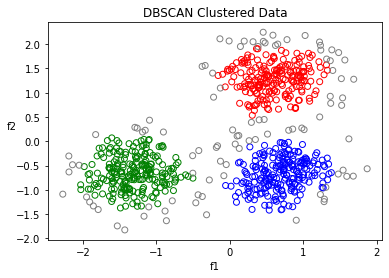

In [30]:
# observe DBSCAN clusters
plt.scatter([x[0] for x in clusterdb0], [y[1] for y in clusterdb0], color='r', facecolors='none')
plt.scatter([x[0] for x in clusterdb1], [y[1] for y in clusterdb1], color='g', facecolors='none')
plt.scatter([x[0] for x in clusterdb2], [y[1] for y in clusterdb2], color='b', facecolors='none')

plt.scatter([x[0] for x in outliers], [y[1] for y in outliers], color='gray', facecolors='none')

plt.xlabel('f1')
plt.ylabel('f2', rotation='horizontal')
plt.title('DBSCAN Clustered Data')

plt.show()

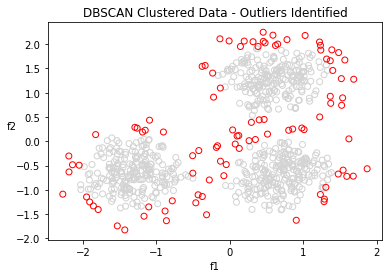

In [31]:
# observe outliers
plt.scatter([x[0] for x in clusterdb0], [y[1] for y in clusterdb0], color='lightgray', facecolors='none')
plt.scatter([x[0] for x in clusterdb1], [y[1] for y in clusterdb1], color='lightgray', facecolors='none')
plt.scatter([x[0] for x in clusterdb2], [y[1] for y in clusterdb2], color='lightgray', facecolors='none')

plt.scatter([x[0] for x in outliers], [y[1] for y in outliers], color='r', facecolors='none')

plt.xlabel('f1')
plt.ylabel('f2', rotation='horizontal')
plt.title('DBSCAN Clustered Data - Outliers Identified')

plt.show()

# Problem #5

In [32]:
clean_df = df_db[(df_db["cluster_label"] != -1)]

# remap cluster_label to 0-index based for consistency
clean_df = clean_df.replace({"cluster_label":{1:0, 2:1, 3:2}})

In [33]:
print(f'Removed {len(df_db) - len(clean_df)} outliers')

Removed 97 outliers


In [34]:
clean_df.head()

,f1,f2,cluster_label
0,0.494261,1.451067,0
1,-1.428081,-0.837064,1
2,0.338559,1.038759,0
3,0.119001,-1.053976,2
4,1.122425,1.774937,0


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import run, PIPE

import graphviz
import pydot

In [36]:
clean_X = clean_df[["f1", "f2"]].values
clean_y = clean_df["cluster_label"].values

In [37]:
tree_clf = DecisionTreeClassifier(random_state=0)

In [38]:
model = tree_clf.fit(clean_X, clean_y)

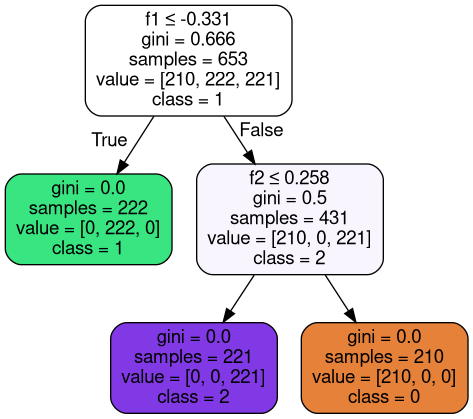

In [39]:
dot_data = export_graphviz(tree_clf,
                           out_file='clean_tree.dot',
                           feature_names=clean_df.columns[:-1],
                           class_names=np.array(["0","1","2"]),
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Convert the DOT file to PNG
run(['dot', '-Tpng', 'clean_tree.dot', '-o', 'clean_tree.png', '-Gdpi=60'], shell=True)

(graph,) = pydot.graph_from_dot_file('clean_tree.dot')
graph.write_png('clean_tree.png')

# Display the decision tree
Image(filename = 'clean_tree.png')

# Problem #6

In [40]:
# get dataset with labels and outliers included
_cluster0 = np.append(cluster0, np.zeros(len(cluster0)).reshape(len(cluster0), 1), axis=1)
_cluster1 = np.append(cluster1, (np.zeros(len(cluster1))+1).reshape(len(cluster1), 1), axis=1)
_cluster2 = np.append(cluster2, (np.zeros(len(cluster2))+2).reshape(len(cluster2), 1), axis=1)

part1 = np.append(_cluster0, _cluster1, axis=0)
_all = np.append(part1, _cluster2, axis=0)

_df = pd.DataFrame(_all, columns=[["f1","f2","cluster_label"]])

In [41]:
_df["cluster_label"] = _df["cluster_label"].astype(int)

In [42]:
_df.head()

,f1,f2,cluster_label
0,-1.428081,-0.837064,0
1,-1.261570,0.271881,0
2,-1.301548,-0.762062,0
3,-1.215782,-0.601021,0
4,-1.250218,-1.057617,0


In [43]:
X = _df[["f1", "f2"]].values
y = _df["cluster_label"].values

In [44]:
tree2_clf = DecisionTreeClassifier(random_state=0)

In [45]:
model2 = tree2_clf.fit(X, y)

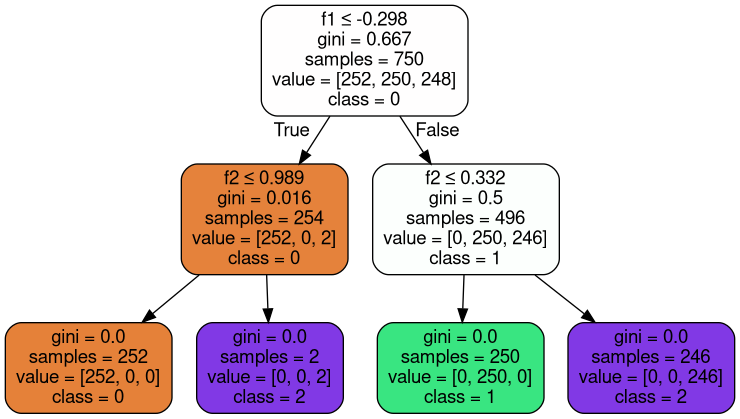

In [46]:
dot_data2 = export_graphviz(tree2_clf,
                           out_file='out_tree.dot',
                           feature_names=df_db.columns[:-1],
                           class_names=np.array(["0","1","2"]),
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Convert the DOT file to PNG
run(['dot', '-Tpng', 'out_tree.dot', '-o', 'out_tree.png', '-Gdpi=60'], shell=True)

(graph,) = pydot.graph_from_dot_file('out_tree.dot')
graph.write_png('out_tree.png')

# Display the decision tree
Image(filename = 'out_tree.png')